# Preliminary
In this notebook I want to get a sense about the two biggest challenges i see in my proposal architecture and the Optional Multi Task loss function, where sometimes some of the tasks are not defined. This will also give me insight in the computational requirements of this network. 

I will make use of a smaller dataset from epicurious.com and jamieoliver.com. For this purpose I make use of the https://github.com/brandonmburroughs/RecipesScraper scraper.

## Dataset
Our dataset consist of large json files. We got about 27,500 recipes from epicurious and 2,300 from jamieoliver.com.   Since we want to base our architecture on a convolutional neural network we need to set a fixed size for the ingredient text size and a fixed size for the number of ingredients. We can pad the smaller ingredients or recipes, but still the larger our fixed sizes the slower our training will be. To get a sense of what make sense we will first count the ingredient sizes and the recipe sizes. 

For each recipe we have a name, a list of ingredients and a list of tags. The basically is a catch all tag field that includes cusine, type of meal. 

In [1]:
import os
import sys
#code folder
sys.path.append("../code/")
import json 
import matplotlib.pyplot as plt
import operator
from IPython.display import HTML, display
import numpy as np
import requests
import re
from urlparse import urlparse
import hashlib
%matplotlib inline

I save my datasets on stack, this way i can download it easily from any machine

In [2]:
from dataset import download_file_from_url,extract_zip_into
CACHE_FOLDER = ".cache/"
RECIPE_DATASET = 'http://datasets.stijnvoss.com/recipes/preliminary.zip'

def download_if_not_exists(RECIPE_DATASET):
    folder = os.path.join(CACHE_FOLDER,hashlib.md5(RECIPE_DATASET).hexdigest())
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    does_exists = len([fn for fn in os.listdir(folder) if fn[-5:] == '.json']) > 0
    if not does_exists:
        print "Dataset not available, downloading from %s" % RECIPE_DATASET
        tmp_file = os.path.join(folder,'data.zip')
        download_file_from_url(RECIPE_DATASET,tmp_file)
        extract_zip_into(tmp_file, folder)
        os.remove(tmp_file)
        
    return folder

### General helpers functions

In [3]:
def _extract_tags(recipe):
    if type(recipe['tags']) is not list:
        recipe['tags'] = [recipe['tags']]
    for tag in recipe['tags']:
        if type(tag) is not list:
            yield tag  
        else:
            for t in tag:
                yield t    
def tokenize(line):
    line = line.replace("<br>", " ").replace(". ", " <eos> ").lower()
    for token in re.findall("[\w\<\>]+", line, re.UNICODE):
        yield token
        
def _read_recipes(dataset_url):
    folder = download_if_not_exists(dataset_url)
    for filename in os.listdir(folder):
        json_file = os.path.join(folder, filename)
        if os.path.isfile(json_file) and filename[-5:] == '.json':
            with open(json_file,'r') as io:
                data = json.load(io)
                for recipe in data['recipes']:
                    yield recipe


### Statistics
Some simple statistics about or dataset to come decide on our max character length and max recipe size

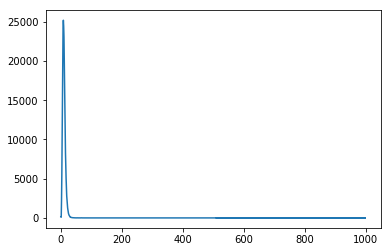

16 0.9
19 0.95
21 0.975
31 0.995
172 0.999


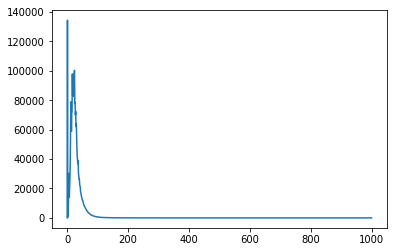

46 0.9
58 0.95
71 0.975
91 0.99
207 0.999


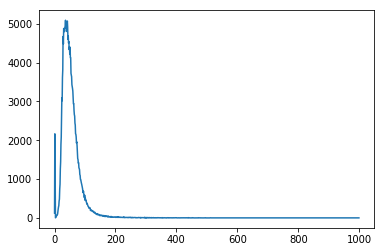

86 0.9
104 0.95
129 0.975
259 0.995
483 0.999


American: 95373,Bake: 56451,Quick & Easy: 47599,Dessert: 43111
Dinner: 37219,Side: 29644,Vegetarian: 26951,Vegetable: 24096
Chicken: 21855,Soup/Stew: 21808,Appetizer: 19834,Healthy: 19466
Italian: 18544,Salad: 16560,Fruit: 15044,Beef: 15039
Peanut Free: 14687,Soy Free: 14345,Cheese: 13673,Cake: 13577
Wheat/Gluten-Free: 13546,Chocolate: 13214,Bon Appétit: 12890,Tree Nut Free: 12508
Sauté: 12097,Kosher: 11863,Cookies: 11691,Egg: 11475
Breakfast: 11382,No-Cook: 11371,Kid-Friendly: 11222,Pasta: 11213
Pescatarian: 10995,Bread: 10703,Fish: 10688,Christmas: 9835
Tomato: 9473,Potato: 9300,Summer: 9274,Gourmet: 9253
Pork: 9053,Mexican: 8620,Bean: 8445,Thanksgiving: 8370


In [5]:
def get_ds_statictics(dataset_url):
    ingredient_sizes = {}
    max_ing_size_per_recipe = {}
    recipe_sizes = {}
    tags = {}
    
    for recipe in _read_recipes(dataset_url):
        for t in _extract_tags(recipe):
            if t not in tags:
                tags[t] = 0
            tags[t] += 1
        recipe_len = len(recipe['ingredients'])
        if recipe_len not in recipe_sizes:
            recipe_sizes[recipe_len] = 0
        recipe_sizes[recipe_len] += 1
        ing_size = 0
        for ingredient in recipe['ingredients']:
            ingredient_len = len(ingredient)
            if ingredient_len not in ingredient_sizes:
                ingredient_sizes[ingredient_len] = 0
            if ingredient_len > ing_size:
                ing_size = ingredient_len
            ingredient_sizes[ingredient_len] += 1
        if ing_size not in max_ing_size_per_recipe:
            max_ing_size_per_recipe[ing_size] = 0
        max_ing_size_per_recipe[ing_size] += 1
                
    return ingredient_sizes, max_ing_size_per_recipe, recipe_sizes, tags
                    
                
def print_percentages(counts, percent=[.9,.95,.975,.99,.999]):
    total = float(sum(counts.values()))
    till_now = 0
    for x,y in counts.iteritems():
        till_now += y
        if till_now/total >= percent[0]:
            print x,percent[0]
            percent = percent[1:]
            
        
        if len(percent) < 1:
            break
    

ingredient_sizes, max_ing_size_per_recipe, recipe_sizes, tags = get_ds_statictics(RECIPE_DATASET)
display(HTML("<h3>Recipes</h3>"))
plt.plot(recipe_sizes.keys(), recipe_sizes.values())
plt.show()
print_percentages(recipe_sizes, percent=[.9,.95,.975,.995,.999])

display(HTML("<h3>Ingredients</h3><p>We inspect the distribution of the number of  characters per ingredient and of the longest per recipe. The latter is usefull if we want to discard recipes with to long ingredient sizes.</p><h4>Ingredient sizes</h4>"))
plt.plot(ingredient_sizes.keys(), ingredient_sizes.values())
plt.show()
print_percentages(ingredient_sizes)
display(HTML("<h4>Longest ingredient length</h4> "))
plt.plot(max_ing_size_per_recipe.keys(), max_ing_size_per_recipe.values())
plt.show()
print_percentages(max_ing_size_per_recipe, percent=[.9,.95,.975,.995,.999])

display(HTML("<h3>Tags</h3>"))
#sort tags to show top N
tags = sorted(tags.items(), key=operator.itemgetter(1),reverse=True)
N = 100
PER_ROW = 4
row = ""
counter = 0

html = "<table><tbody><tr>"
for t,c in tags:
    counter +=1
    html += "<td><strong>%s</strong>: %d</td>" % (t,c)
    if counter % PER_ROW == 0:
        html += "</tr><tr>"
    if counter > N:
        break
html += "</tr></tbody></table>"
    
display(HTML(html)) 
display(HTML("<h3>Names</h3>"))

### Build dataset
We will fix the ingredient text size to 128 or 256 characters and set the number of ingredients to 32. We will compare performance for text size in terms of performance and task performance. We will remove the complete recipe if the number of ingredients or text size exceeds the limit. 

We are going to build a dataset with the following data per recipe:
- **X_char**: Each recipe thus consists of a 32x(128|256) matrix of 8-bit unsigned integers. With 8-bit integers we can represents alphabet size up to 255 characters. One hot encoding will happen on run-time
- **X_words**: Sparse vector of 8-bit integers representing counts of . Can be used for a
- **Y_name**: Sparse vector of 8-bit integers representing counts of words occurences in the names. Words that occur less then 5 times over the whole dataset will be filtered out. 
- **Y_vegetarian**: 8-bit integer 0 if not known, 1 if vegetarian, 2 if not vegatarian. 
- **Y_cusine**: 8-bit integer 0 if not know, idx number depending on the list of cuisines given for every other cuisine

We will also build the following vocabularies along with the data above:
- **Alphabet:** The alphabet used to learn this data
- **Ingredient words:** For the words found in the ingredients
- **Name words:** For the words found in the names

Please note that we assume that the tags are always correctly used. So a meal is nog tagged with containing meat and being vegetarian at the same time

In [13]:
# By default we use the hash of arguments of build_dataset to cache the dataset. 
# set to NONE to prevent caching behaviour
import scipy.sparse
VEGAN = ['vegetarian','vegan']
MEAT = ['fish','chicken','pork','beef','pork recipes','lamb','beef recipes','duck','duck recipes','turkey','turkey recipes','seafood recipes','seafood','lamb recipes']
CUISINES = ['italian','asian','american','french','indian','british','mexican','chinese','mediterranean']

def create_alphabet(case_sensitive=True, digits=True, others="%.&[]()%!~-+ "):
    """ Creates dictionary from character to integer index, also creates inverse
    """
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    if case_sensitive:
        alphabet += alphabet.upper()
    if digits:
        alphabet += "0123456789"
    alphabet += others
    # 0 is catch all
    return dict([(a,i+1) for i,a in enumerate(alphabet)]),dict([(i+1,a) for i,a in enumerate(alphabet)])


def _determine_labels(recipe, veg_tags, meat_tags, cus_tags):
    """ Helper function that determines cusine and vegetarian label for a recipe
    """
    veg = 0
    cus = 0
    for t in _extract_tags(recipe):
        t = t.lower()
        if t in veg_tags:
            veg = 1
        elif t in meat_tags:
            veg = 2
        if t in cus_tags:
            cus = cus_tags.index(t) + 1
    return veg,cus

def find_chars(ingredient, text_size, max_text_size, char2int):
    chars = []
    for ci in xrange(max_text_size):
        if ci < text_size and ingredient[ci] in char2int:
            chars.append(char2int[ingredient[ci]])
        else:
            chars.append(0) #padding and catch-all
    return chars

def map_word_sequence(input_string, inv_voc, counter=None):
    """
    Tokenizes a string into sequence of ints, based on vocobulary
    Will also expand vocabular if neccesary
    """
    seq = []
    for token in tokenize(input_string):
        if token not in inv_voc:
            inv_voc[token] = len(inv_voc)
        idx = inv_voc[token]
        seq.append(idx)
        if counter is not None:
            if idx not in counter:
                counter[idx] =0
            counter[idx] += 1
            
    return seq

def _map_to_new_voc(Y,mapping):
    """Maps from old voc to new voc recusivly in case you want to rewrite your vocu"""
    if type(Y) is list:
        return [x for x in [_map_to_new_voc(y,mapping) for y in Y] if x is not None]
    elif Y in mapping:
        return mapping[Y]
    else:
        None

# Shared helping functions
def create_normal_voc(voc):
    """ Creates inverse vocabulary from word to index
    """
    l = ['' for v in xrange(len(voc))]
    for w,i in voc.iteritems():
        l[i] = w
    return l
    
        
        
def apply_threshold_to_voc(Y, inv_voc, voc_counter, min_th):
    voc = create_normal_voc(inv_voc)
    
    #create new mapping going from old idx to new
    new_mapping = {}
    new_voc = {} #also build new vocubulary
    for x,y in voc_counter.iteritems():
        if y >= min_th:
            idx = len(new_mapping)
            new_mapping[x] = idx
            new_voc[voc[x]] = idx
            
    #then walk over sequences:
    return _map_to_new_voc(Y, new_mapping),new_voc

def convert_to_count_array(sequences, dtype=np.int8,max_value=None):
    """ Gets a list of sequences of integers,
    """
    if max_value is None:
        max_value = max([max(s) for s in sequences if len(s) > 0])
    X = np.zeros((len(sequences),max_value+1),dtype=dtype)
    for idx in xrange(len(sequences)):
        sequence=sequences[idx]
        for s in sequence:
            X[idx,s] += 1
    return X
    
            

def build_dataset(dataset_url, case_sensitive=True, digits=True, others="%.&[]()%!~-+ ",cusines=CUISINES,vegetarian=VEGAN,meat=MEAT,name_th=5,max_text_size=128,max_recipe_size=32):
    function_str = ".".join([str(l) for l in locals()])
    npz_file = os.path.join(CACHE_FOLDER, hashlib.md5(function_str).hexdigest()+".npz")
    if not os.path.exists(npz_file):
        char2int, int2char = create_alphabet(case_sensitive, digits, others)
        if len(int2char) > 255:
            raise Exception("Alphabet size of %d exceeds maximum of 255 characters")
        X_char = []
        X_words = []
        voc_ingredients = {}
        voc_names = {}
        voc_names_counter = {}

        Y_cuisine = []
        Y_vegetarian = []
        Y_names = []
        counter = 0
        LIMIT = 1000
        for recipe in _read_recipes(dataset_url):
            if recipe['recipe_name'] is None:
                continue

            #name
            names = map_word_sequence(recipe['recipe_name'],voc_names,voc_names_counter)

            #Ingredients:
            chars = []
            words = []
            if len(recipe['ingredients']) > max_recipe_size:
                continue

            for ingredient in recipe['ingredients']:
                #chars
                l = len(ingredient)
                if l > max_text_size:
                    continue
                if not case_sensitive:
                    ingredient.lower()
                chars.append(find_chars(ingredient, l, max_text_size, char2int))
                words.extend(map_word_sequence(ingredient,voc_ingredients))

            for i in xrange(len(chars),max_recipe_size):
                chars.append([0 for i in xrange(max_text_size)])

            X_char.append(chars)
            X_words.append(words)
            Y_names.append(names)

            # Label:
            veg,cus = _determine_labels(recipe, vegetarian, meat, cusines)
            Y_cuisine.append(cus)
            Y_vegetarian.append(veg)
            counter += 1


        #This removes names of recipes that are below the threshold and creates new vocabulary
        Y_names,voc_names = apply_threshold_to_voc(Y_names, voc_names, voc_names_counter,name_th )
        # While building this dataet it was easier to used in the inversed vocubalaries,
        # But for numpy we are going to need lists..
        voc_names = create_normal_voc(voc_names)
        voc_ingredients = create_normal_voc(voc_ingredients)
        #convert list of characters manually, also make sure that 0 character is present
        int2char[0] = ''
        char_voc = [int2char[i] for i in xrange(len(int2char))]

        #Lastly we are going to convert everything to numpy before we save it:
        X_char = np.array(X_char,dtype=np.int8)
        X_words = convert_to_count_array(X_words,dtype=np.int8)
        Y_names = convert_to_count_array(Y_names,dtype=np.int8)
        Y_cuisine = np.array(Y_cuisine,dtype=np.int8)
        Y_vegetarian = np.array(Y_vegetarian,dtype=np.int8)

        int2char = np.array(char_voc,dtype=np.unicode_)
        voc_ingredients = np.array(voc_ingredients,dtype=np.unicode_)
        voc_names = np.array(voc_names,dtype=np.unicode_)

        #Save it
        np.savez(npz_file,X_char=X_char,X_words=X_words,Y_names=Y_names,Y_cuisine=Y_cuisine,Y_vegetarian=Y_vegetarian,int2char=int2char,voc_ingredients=voc_ingredients,voc_names=voc_names)
    else:
        data = np.load(npz_file)
        
        X_char,X_words = data['X_char'],data['X_words']
        Y_names,Y_cuisine,Y_vegetarian = data['Y_names'],data['Y_cuisine'],data['Y_vegetarian']
        int2char, voc_ingredients, voc_names = data['int2char'], data['voc_ingredients'], data['voc_names']
    import humanize
    size = humanize.naturalsize(os.path.getsize(npz_file))
    print "Using dataset of %s. Found a total of %d recipes" % (size, X_char.shape[0])
    return (X_char, X_words),(Y_names,Y_cuisine,Y_vegetarian), (int2char, voc_ingredients, voc_names)

(X_char, X_words), (Y_names,Y_cuisine,Y_vegetarian), (int2char, voc_ingredients, voc_names) = build_dataset(RECIPE_DATASET,name_th=5)

Using dataset of 14.5 GB. Found a total of 247880 recipes


#### Dataset size
As you can see we are only processing about 250,000 recipes in this preliminary research. But we are already used 15GB of dataset. If we would scale up to 10 mln as we are originally planning for. We might need another approach. Let's have a look how much storage each part takes:

In [19]:
import humanize
    
save_file = os.path.join(CACHE_FOLDER,'test.npz')
for data in ['X_char','X_words','Y_names','Y_cuisine','Y_vegetarian','int2char','voc_ingredients','voc_names']:
    np.savez(save_file,locals()[data])
    size = humanize.naturalsize(os.path.getsize(save_file))
    print "%s: %s" % (data,size)
    os.remove(save_file)

X_char: 1.0 GB
X_words: 11.8 GB
Y_names: 1.7 GB
Y_cuisine: 248.1 kB
Y_vegetarian: 248.1 kB
int2char: 500 Bytes
voc_ingredients: 12.3 MB
voc_names: 475.7 kB


By far most of the storage is used by the not-sparse-represented matrixes. There should be a lot we can safe when we use save it a more efficient format. And for example pad on run time. 

In [21]:
print "From a total of %d recipes, %d have a cuisine defined" % (len(Y_cuisine),len([x for x in Y_cuisine if x > 0]))
print "From a total of %d recipes, %d have defined the meal to be vegetarion or not" % (len(Y_vegetarian),len([x for x in Y_vegetarian if x > 0]))

From a total of 247880 recipes, 143959 have a cuisine defined
From a total of 247880 recipes, 90575 have defined the meal to be vegetarion or not


## Our loss function